# Module 6 - Feature Selection

Feature Selection is the process of choosing which features to use to answer your central question. Why would anyone want to limit the information availbale to them! Think Ockham's razor - when presented with competing hypotheses about the same prediction, one should select the solution with the fewest assumptions. In short - "the simplest explination is usually the best one". This concept of fugality applied to describing nature is what we call parsimony. In practice, we aim to develop models with the least number of features.

The advantages to this are that models train faster, are less prone to overfitting, and are usually more accurate. In this excercise we will apply various feature selection schemes to the Mobile Price Classification dataset distributed with this notebook to examine how it effects model performance.

 ## About the Mobile Price dataset 
 1. The data is already tidy and partitioned into training and testing csv files. 
 2. There are 2000 observations in the training set and 1000 in testing.
 3. Each observation consisits of 20 phone features (columns) and one categorical label (final column) describing the phone's price range.
 4. This is a classification problem. But for our case, it's an exercise in feature selection.

### Data description
| Feature | Description |
| ------- | ----------- |
| battery_power | Total energy a battery can store in one time measured in mAh |
|blue | Has Bluetooth or not |
|clock_speed | the speed at which microprocessor executes instructions |
|dual_sim | Has dual sim support or not |
| fc | Front Camera megapixels |
| four_g | Has 4G or not |
| int_memory | Internal Memory in Gigabytes |
| m_dep | Mobile Depth in cm |
| mobile_wt | Weight of mobile phone |
| n_cores | Number of cores of the processor |
| pc | Primary Camera megapixels |
| px_height | Pixel Resolution Height |
| px_width | Pixel Resolution Width |
| ram | Random Access Memory in MegaBytes |
| sc_h | Screen Height of mobile in cm |
| sc_w | Screen Width of mobile in cm |
| talk_time | the longest time that a single battery charge will last when you are |
| three_g | Has 3G or not |
| touch_screen | Has touch screen or not |
| wifi | Has wifi or not |
| price_range | This is the target variable with a value of 0(low cost), 1(medium cost), 2(high cost) and 3(very high cost). |

## Setup
Let's get all the requirements sorted before we move on to the excercise. Most packages should be familiar at this point. Numpy, pandas, matplotlib, and seaborn where all introduced in Part I of the workshop in modules 1-3 and last week in module 5 we introduced tableone. Notice, today we will be using sklearn for the first time to do some machine learning. Don't worry too much about the models we'll be using or how to train them for now. This will the the topic for modules 7 & 8.  

In [1]:
# Requirements
!pip install --upgrade ipykernel
#!pip install scipy
!pip install pandas
!pip install numpy
!pip install tableone
!pip install matplotlib
!pip install seaborn
!pip install sklearn

# Globals
seed = 1017

#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tableone import TableOne
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import accuracy_score, matthews_corrcoef, jaccard_score


## What question am I answering?
Well, we want to demonstrate the utility of feature selection. I think a convincing approach would be to compare predictive power in a model with and without feature selection. So, for every parsimonious model we train let's compare its performance with that of its couterpart prodigious model (i.e. model that uses all the features). Let's get started.

## Loading the data
As always we should have a look at how the features are distributed grouped by the labels. For this we'll generate a table 1.

In [2]:
# download the data as a pandas dataframe
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

#Explicitly convert binary variables to bool
binvars = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']
df[binvars] = df[binvars].astype(bool)

# Generate table 1
TableOne(df, groupby=df.columns[-1],
         pval=True,
         dip_test=True,
         normal_test=True,
         tukey_test=True)

Grouped by price_range                                                                                         
                                              Missing          Overall               0               1               2               3 P-Value
n                                                                 2000             500             500             500             500        
battery_power, mean (SD)                            0   1238.5 (439.4)  1116.9 (410.8)  1228.9 (438.6)  1228.3 (452.9)  1380.0 (415.0)  <0.001
blue, n (%)              False                      0      1010 (50.5)      257 (51.4)      255 (51.0)      257 (51.4)      241 (48.2)   0.698
                         True                               990 (49.5)      243 (48.6)      245 (49.0)      243 (48.6)      259 (51.8)        
clock_speed, mean (SD)                              0        1.5 (0.8)       1.6 (0.8)       1.5 (0.8)       1.5 (0.8)       1.5 (0.8)   0.687
dual_sim, n (%)          False                      0       981 (49.0)      250 (50.0)      245 (49.0)      251 (50.2)      235 (47.0)   0.732
                         True                              1019 (50.9)      250 (50.0)      255 (51.0)      249 (49.8)      265 (53.0)        
fc, mean (SD)                                       0        4.3 (4.3)       4.1 (4.2)       4.3 (4.5)       4.5 (4.3)       4.3 (4.3)   0.510
four_g, n (%)            False                      0       957 (47.9)      241 (48.2)      238 (47.6)      253 (50.6)      225 (45.0)   0.365
                         True                              1043 (52.1)      259 (51.8)      262 (52.4)      247 (49.4)      275 (55.0)        
int_memory, mean (SD)                               0      32.0 (18.1)     31.2 (18.1)     32.1 (18.0)     30.9 (18.4)     34.0 (17.9)   0.033
m_dep, mean (SD)                                    0        0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)   0.212
mobile_wt, mean (SD)                                0     140.2 (35.4)    140.6 (36.4)    140.5 (35.7)    143.6 (34.3)    136.3 (34.9)   0.013
n_cores, n (%)           1                          0       242 (12.1)        49 (9.8)       76 (15.2)       52 (10.4)       65 (13.0)   0.488
                         2                                  247 (12.3)       69 (13.8)       59 (11.8)       57 (11.4)       62 (12.4)        
                         3                                  246 (12.3)       62 (12.4)       69 (13.8)       56 (11.2)       59 (11.8)        
                         4                                  274 (13.7)       67 (13.4)       76 (15.2)       73 (14.6)       58 (11.6)        
                         5                                  246 (12.3)       59 (11.8)       51 (10.2)       66 (13.2)       70 (14.0)        
                         6                                  230 (11.5)       61 (12.2)       54 (10.8)       57 (11.4)       58 (11.6)        
                         7                                  259 (13.0)       66 (13.2)       55 (11.0)       69 (13.8)       69 (13.8)        
                         8                                  256 (12.8)       67 (13.4)       60 (12.0)       70 (14.0)       59 (11.8)        
pc, mean (SD)                                       0        9.9 (6.1)       9.6 (6.1)       9.9 (6.1)      10.0 (6.0)      10.2 (6.1)   0.480
px_height, mean (SD)                                0    645.1 (443.8)   536.4 (372.8)   666.9 (441.4)   632.3 (445.8)   744.8 (483.7)  <0.001
px_width, mean (SD)                                 0   1251.5 (432.2)  1150.3 (413.0)  1251.9 (433.6)  1234.0 (427.8)  1369.8 (426.8)  <0.001
ram, mean (SD)                                      0  2124.2 (1084.7)   785.3 (362.8)  1679.5 (465.9)  2582.8 (496.2)  3449.2 (393.0)  <0.001
sc_h, mean (SD)                                     0       12.3 (4.2)      12.3 (4.2)      12.2 (4.2)      12.0 (4.2)      12.7 (4.2)   0.083
sc_w, mean (SD)            

Let's address the 2 warnings raised by the table 1 and see if we have to reformat some of the features.

### Addressing the warnings
Let's have a look at the disributions for those features that appeared in the warnings.

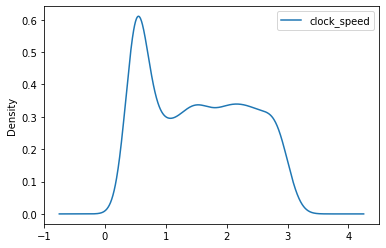

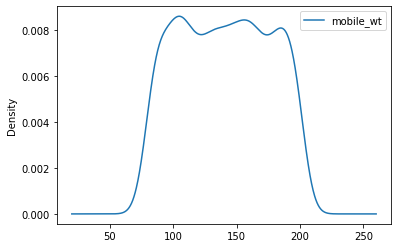

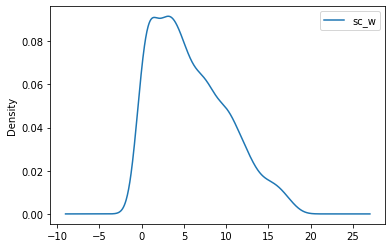

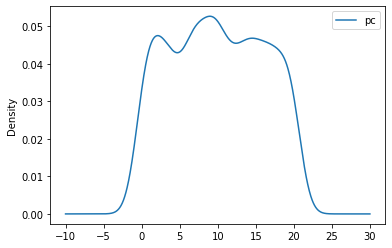

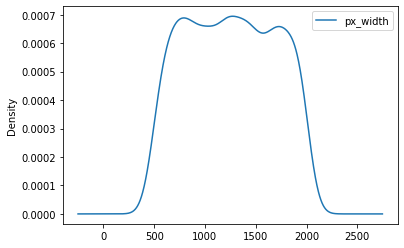

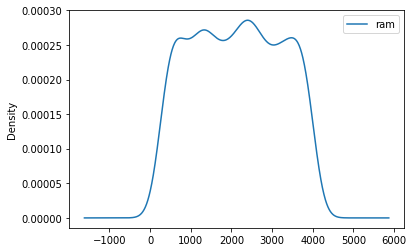

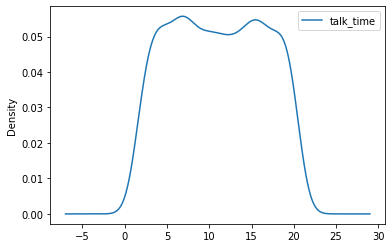

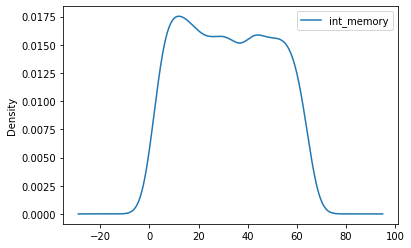

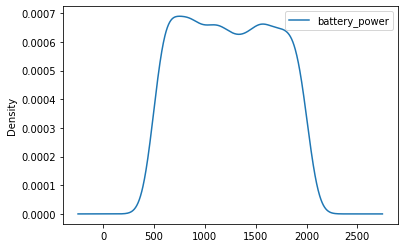

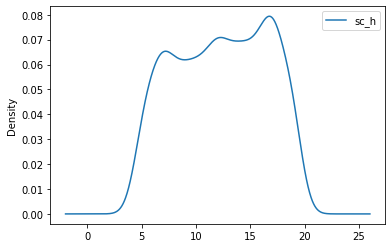

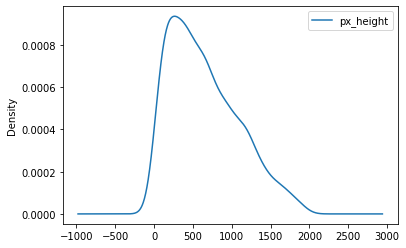

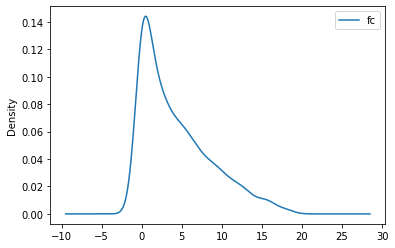

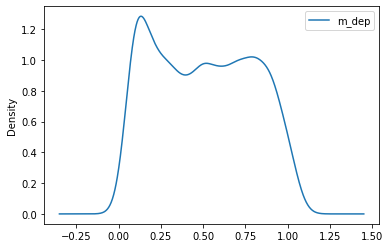

In [3]:
#distributions
dips = ['clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'sc_h', 'sc_w', 'talk_time']
nonnorm = ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']
for feat in set(dips + nonnorm): 
    df[[feat]].dropna().plot.kde(bw_method='scott') #use bw_method=.02 for a lower bandwidth gaussian representation
    plt.legend([feat])
    plt.show()

### Questions:
1. How many modes do you see in clock speed?
2. Why do you think the 'fc' feature has that long tail - how would you treat it?
3. Would you transfrom any other variables - why and how?

## Normalization
Even though the source data has no missing values it would be wrong to assume it is tidy. Also anything we do to the testing set we have to do to the testing set too.

### Zero values
Looks like the features for screen width (sc_w), primary cammera megapixels (pc), pixel resolution height (px_height), and front cammera megapixels (fc) all have zero values. I think these values don't represent what they intend to represent. One can guess that if pc or fc are 0 then it means the phone doesn't have a primary or front facing cammera not that the cammera has 0 megapixles. Maybe the same could be said about sc_w and px_height to mean there is no screen but this is hard to believe. Does this mean we have Zack Moris phones? If this is true then why are there no zero values for screen height (sc_h) or for pixel resolution width (px_width). I would go out on a limb and say the zeros in sc_w and px_height are actually missing values.

One fix for the pc fc variables is to binerize them to has_pc and has_fc; for sc_w and px_height we could replace the zeros with their mean values. But, I think the easiest fix is to remove observations with the zero values. There are better ways to do this of course but this is a feature selection excercise not a data cleaning one. I'll leave it to you to try a more sophisticated approach if you are game - maybe your models will ultimately perform better than the ones we produce today.

In [4]:
# replace zeros in pc and fc with NaNs
cols = ['pc', 'fc', 'sc_w', 'px_height']
df[cols] = df[cols].replace({0:np.nan})
df_test[cols] = df_test[cols].replace({0:np.nan})

#drop observations with missing values
df.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)

Let's replace the zeros in sc_w and px_height with their mean values. Again, there are better ways to do this too. 

In [5]:
#preplace zeros in in sc_w and px_height with np.nan 
#cols = ['sc_w', 'px_height']
#df[cols] = df[cols].replace({0:np.nan})
#df_test[cols] = df_test[cols].replace({0:None})

#impute any missing values with their column median
#df.fillna(value=df.median(axis=1, skipna=True), inplace=True)
#df_test.fillna(value=df_test.median(axis=1, skipna=True), inplace=True)

### Long tails
Long tails are usually tucked in with a log tranform. Note, log(x) is defined for all positive x. Fortunately we have not negative values and we just go rid of the zero values so we can safely log transform these variables. We noticed fc, px_height, and sc_w had tails so lets log2 transform them.

In [6]:
#log2 transform fc, px_height, and sc_w 
cols = ['fc', 'px_height', 'sc_w' ]
df[cols] = np.log2(df[cols])
df_test[cols] = np.log2(df_test[cols])

### Multimodes
Clock speed is also particualarly problematic, notice how there are a lot of phones with clock speed less than 1 (units not specified) and the rest have clock speeds between 1-3. One easy fix is to bin these into fast and slow phones to capture these multiple modes.

In [7]:
#convert clock speed into isfast bool
df['clock_speed'] = df['clock_speed'] > 1
df_test['clock_speed'] = df_test['clock_speed'] > 1

#convert bool to 1 and 0
df['clock_speed'] =df['clock_speed'].astype(int)
df_test['clock_speed'] =df_test['clock_speed'].astype(int)

### Double check Normalization
Let's replot the feature distribtuions again to see if the data look more like gaussian distributions. Ideally, the data will all look like bell curves but in practice this is rarely the case. Frankly, I would be skeptical if the data did look this way. What we are looking for is the data to occupy one continuous block of values. 

In [8]:
# Regenerate table 1
display(TableOne(df, groupby=df.columns[-1],
         pval=True,
         dip_test=True,
         normal_test=True,
         tukey_test=True))

Grouped by price_range                                                                                         
                                              Missing          Overall               0               1               2               3 P-Value
n                                                                 1393             343             338             349             363        
battery_power, mean (SD)                            0   1241.4 (443.4)  1114.3 (403.1)  1228.6 (448.3)  1228.0 (459.4)  1386.4 (419.3)  <0.001
blue, n (%)              False                      0       697 (50.0)      177 (51.6)      169 (50.0)      177 (50.7)      174 (47.9)   0.791
                         True                               696 (50.0)      166 (48.4)      169 (50.0)      172 (49.3)      189 (52.1)        
clock_speed, n (%)       0                          0       514 (36.9)      128 (37.3)      139 (41.1)      125 (35.8)      122 (33.6)   0.214
                         1                                  879 (63.1)      215 (62.7)      199 (58.9)      224 (64.2)      241 (66.4)        
dual_sim, n (%)          False                      0       701 (50.3)      177 (51.6)      166 (49.1)      184 (52.7)      174 (47.9)   0.561
                         True                               692 (49.7)      166 (48.4)      172 (50.9)      165 (47.3)      189 (52.1)        
fc, mean (SD)                                       0        2.0 (1.2)       2.0 (1.2)       2.0 (1.3)       2.1 (1.2)       2.0 (1.2)   0.318
four_g, n (%)            False                      0       677 (48.6)      168 (49.0)      164 (48.5)      175 (50.1)      170 (46.8)   0.848
                         True                               716 (51.4)      175 (51.0)      174 (51.5)      174 (49.9)      193 (53.2)        
int_memory, mean (SD)                               0      32.0 (18.2)     30.3 (18.1)     32.6 (18.1)     31.3 (18.5)     33.8 (18.1)   0.060
m_dep, mean (SD)                                    0        0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)       0.5 (0.3)   0.296
mobile_wt, mean (SD)                                0     141.2 (35.6)    141.7 (37.2)    139.9 (36.5)    144.5 (33.6)    138.7 (34.9)   0.154
n_cores, mean (SD)                                  0        4.5 (2.3)       4.7 (2.3)       4.3 (2.3)       4.6 (2.3)       4.4 (2.3)   0.111
pc, mean (SD)                                       0       11.5 (5.3)      11.4 (5.2)      11.4 (5.4)      11.6 (5.1)      11.4 (5.4)   0.894
px_height, mean (SD)                                0        8.8 (1.4)       8.5 (1.5)       8.9 (1.4)       8.8 (1.4)       9.1 (1.4)  <0.001
px_width, mean (SD)                                 0   1251.1 (432.6)  1164.6 (419.2)  1251.4 (431.5)  1218.7 (426.8)  1363.9 (429.5)  <0.001
ram, mean (SD)                                      0  2149.9 (1086.7)   779.3 (344.2)  1697.3 (470.9)  2592.9 (490.5)  3440.6 (400.6)  <0.001
sc_h, mean (SD)                                     0       12.5 (4.2)      12.4 (4.2)      12.4 (4.2)      12.2 (4.1)      13.0 (4.1)   0.061
sc_w, mean (SD)                                     0        2.3 (1.1)       2.3 (1.1)       2.2 (1.1)       2.3 (1.1)       2.3 (1.2)   0.640
talk_time, mean (SD)                                0       11.0 (5.4)      10.9 (5.4)      11.2 (5.6)      11.0 (5.3)      11.0 (5.4)   0.875
three_g, n (%)           False                      0       348 (25.0)       93 (27.1)       84 (24.9)       80 (22.9)       91 (25.1)   0.654
                         True                              1045 (75.0)      250 (72.9)      254 (75.1)      269 (77.1)      272 (74.9)        
touch_screen, n (%)      False                      0       697 (50.0)      165 (48.1)      164 (48.5)      187 (53.6)      181 (49.9)   0.461
                         True                               696 (50.0)      178 (51.9)      174 (51.5)      162 (46.4)      182 (50.1)        
wifi, n (%)              Fa

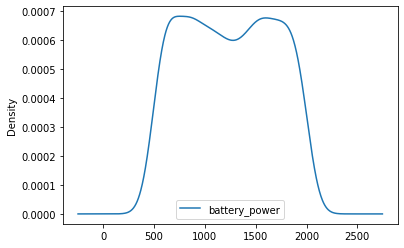

TypeError: no numeric data to plot

In [9]:
#plot all distributions
for feat in df.columns: 
    df[[feat]].dropna().plot.kde() 
    plt.legend([feat])
    plt.show()

To me, fc and sc_w still look like there is a whole in the distribution. One fix would be to bin them into tertiles but I will leave that as an excercise for you.

## Usupervised Methods
**Remove highly correlated features** To remove the correlated features, we can make use of the corr() method of the pandas dataframe. The corr() method returns a correlation matrix containing correlation between all the columns of the dataframe. A useful way to visualize the correlations is with a heatmap. We'll use the seaborn library for this.

In [ ]:
#Create a correlation matrix for the columns in the dataset
correlation_matrix = df.corr()

#plot heat map
plt.figure(figsize=(20,20))
g=sns.heatmap(correlation_matrix, annot=True, cmap="RdYlGn")

We can loop through all the columns in the correlation_matrix and keep track of the features with a correlation value > 0.5. This 0.5 cut-off is quite strict and chosen for demonstration purposes. A more reasonable value is 80-90%. 

In [ ]:
#init an empty set that will contain the names of the correlated features
correlated_features = set()

#loop over lower triangle of pairs of features
#     do not consider the last feature which is the label 
for i in range(len(correlation_matrix .columns) - 1):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.5:
            #accumulate the names of the second correlated feature
            colname = correlation_matrix.columns[j]
            correlated_features.add(colname)

In [ ]:
#display the correlated features
display(correlated_features)

These features are correlated to at least one other feature and can be considered redundant. Let's not include them in our parsimonious set and see how it effects model performance.

In [ ]:
# get training predictors and labels
X = df.iloc[:,0:20]  #independent columns
Y = df.iloc[:,-1]    #target column i.e price range

# get testing predictors and labels
X_test = df_test.iloc[:,0:20]  #independent columns
Y_test = df_test.iloc[:,-1]    #target column i.e price range

# get a copy of the reduced predictors
Xred = X.drop(labels=correlated_features, axis=1, inplace=False)
Xred_test = X_test.drop(labels=correlated_features, axis=1, inplace=False)

#define standardization (don't worry about this part)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)
scaler = preprocessing.StandardScaler().fit(Xred)
Xred = scaler.transform(Xred)
Xred_test = scaler.transform(Xred_test)




#plot all distributions
dfx = pd.DataFrame(data=X, columns=df.columns[:-1])
for feat in dfx.columns: 
    dfx[[feat]].dropna().plot.kde() 
    plt.legend([feat])
    plt.show()

#define standardization (don't worry about this part)
#X = preprocessing.StandardScaler().fit(X).transform(X)
#X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
#Xred = preprocessing.StandardScaler().fit(X).transform(X)
#Xred_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)



In [ ]:
#define the prodigious and parsimonious logistic models
prodmodel = linear_model.LogisticRegression(penalty='none')
parsmodel = linear_model.LogisticRegression(penalty='none')

#Fit the models
prodmodel.fit(X, Y)
parsmodel.fit(Xred, Y) 

#make predictions
Yhat_prod = prodmodel.predict(X_test)
Yhat_pars = parsmodel.predict(Xred_test)

#Report errors
display('Prodigious Model Accuracy: %.2f' %accuracy_score(Y_test, Yhat_prod))
display('Parsimonious Model Accuracy: %.2f' %accuracy_score(Y_test, Yhat_pars))

display('Prodigious Model Matthews corr coef: %.2f' %matthews_corrcoef(Y_test, Yhat_prod))
display('Parsimonious Model Matthews corr coef: %.2f' %matthews_corrcoef(Y_test, Yhat_pars))

display('Prodigious Model Jaccard: %.2f' %jaccard_score(Y_test, Yhat_prod))
display('Parsimonious Model Jaccard: %.2f' %jaccard_score(Y_test, Yhat_pars))
